# HR Analytics: Employee Retention

Goals of this mini project:

1. to investigate what reasons potentially made the employees of a company leave their jobs in the past;
2. to build a model that can accurately predict when other employees are about to leave the company.

Needless to say that this kind of information could be very useful for any company since it helps spotting management deficiencies and avoiding expenses related to employee turnover, among other benefits.

For this task, a data set containing information about ~15000 employees was used. Different learning algorithms are applied to build the predictive models, and their results are evaluated in terms of sensibility, specificity and the area under the Receiver Operating Characteristic (ROC) curve.

In [1]:
library(plyr)
library(dplyr)
library(ggplot2)
library(corrplot)
library(caret)
library(rpart.plot)
library(e1071)
library(ROCR)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: rpart
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



## 1 Data load

In [2]:
# The data set is in CSV format.
df <- read.csv('raw_data.csv')

In [3]:
# Get the size of the data set.
dim(df)

[1] 14999    12

In [4]:
# Basic description.
str(df)

'data.frame':	14999 obs. of  12 variables:
 $ name                  : Factor w/ 14999 levels "AARON","ABAD",..: 12684 6923 14613 1753 6933 9378 3296 4951 11577 14631 ...
 $ satisfaction_level    : num  0.38 0.8 0.11 0.72 0.37 0.41 0.1 0.92 0.89 0.42 ...
 $ last_evaluation       : num  0.53 0.86 0.88 0.87 0.52 0.5 0.77 0.85 1 0.53 ...
 $ number_projects       : int  2 5 7 5 2 2 6 5 5 2 ...
 $ average_monthly_hours : int  157 262 272 223 159 153 247 259 224 142 ...
 $ time_spent_company    : int  3 6 4 5 3 3 4 5 5 3 ...
 $ work_accident         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ left                  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ promotion_last_5_years: int  0 0 0 0 0 0 0 0 0 0 ...
 $ department            : Factor w/ 10 levels "accounting","hr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ salary                : Factor w/ 3 levels "high","low","medium": 2 3 3 2 2 2 2 2 2 2 ...
 $ salary_level          : int  1 2 2 1 1 1 1 1 1 1 ...


In [5]:
# Min, max, mean, median, quartiles and frequencies.
summary(df)

      name       satisfaction_level last_evaluation  number_projects
 AARON  :    1   Min.   :0.0900     Min.   :0.3600   Min.   :2.000  
 ABAD   :    1   1st Qu.:0.4400     1st Qu.:0.5600   1st Qu.:3.000  
 ABALOS :    1   Median :0.6400     Median :0.7200   Median :4.000  
 ABARCA :    1   Mean   :0.6128     Mean   :0.7161   Mean   :3.803  
 ABATE  :    1   3rd Qu.:0.8200     3rd Qu.:0.8700   3rd Qu.:5.000  
 ABBAS  :    1   Max.   :1.0000     Max.   :1.0000   Max.   :7.000  
 (Other):14993                                                      
 average_monthly_hours time_spent_company work_accident         left       
 Min.   : 96.0         Min.   : 2.000     Min.   :0.0000   Min.   :0.0000  
 1st Qu.:156.0         1st Qu.: 3.000     1st Qu.:0.0000   1st Qu.:0.0000  
 Median :200.0         Median : 3.000     Median :0.0000   Median :0.0000  
 Mean   :201.1         Mean   : 3.498     Mean   :0.1446   Mean   :0.2381  
 3rd Qu.:245.0         3rd Qu.: 4.000     3rd Qu.:0.0000   3rd Qu.:0

In [6]:
# Count missing values.
sapply(df, function(x) { sum(is.na(x)) })

name     satisfaction_level        last_evaluation 
                     0                      0                      0 
       number_projects  average_monthly_hours     time_spent_company 
                     0                      0                      0 
         work_accident                   left promotion_last_5_years 
                     0                      0                      0 
            department                 salary           salary_level 
                     0                      0                      0

In [7]:
# First 5 observations.
head(df)

name,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5_years,department,salary,salary_level
SMITH,0.38,0.53,2,157,3,0,1,0,sales,low,1
JOHNSON,0.80,0.86,5,262,6,0,1,0,sales,medium,2
WILLIAMS,0.11,0.88,7,272,4,0,1,0,sales,medium,2
BROWN,0.72,0.87,5,223,5,0,1,0,sales,low,1
JONES,0.37,0.52,2,159,3,0,1,0,sales,low,1
MILLER,0.41,0.50,2,153,3,0,1,0,sales,low,1


In [8]:
# Last 5 observations.
tail(df)

,name,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5_years,department,salary,salary_level
14994,ARTER,0.76,0.83,6,293,6,0,1,0,support,low,1
14995,WELDY,0.40,0.57,2,151,3,0,1,0,support,low,1
14996,VINTON,0.37,0.48,2,160,3,0,1,0,support,low,1
14997,SALIBA,0.37,0.53,2,143,3,0,1,0,support,low,1
14998,PARMAR,0.11,0.96,6,280,4,0,1,0,support,low,1
14999,OSTLER,0.37,0.52,2,158,3,0,1,0,support,low,1


So the data set contains exactly 14999 observations, each described by 12 features:

* `name`: employee's last name.
* `satisfaction_level`: employee's satisfaction, as a 0-1 score.
* `last_evaluation`: employee's score in the last evaluation, as a 0-1 score.
* `number_projects`: number of projects the employee has worked on.
* `average_monthly_hours`: average working hours per month.
* `time_spent_company`: how long (years) the employee works at the company.
* `work_accident`: values 1 if the employee has had any work accident, and 0 otherwise.
* `left`: values 1 if the employee has left the company, and 0 otherwise.
* `promotion_last_5_years`: values 1 if the employee has received a promotion in the last 5 years, and 0 otherwise.
* `department`: department the employee works in.
* `salary`: employee's salary level ("low", "medium", "high").
* `salary_level`: employee's salary level as a number (1, 2, 3).

There are no missing values to be filled.

`left` is the target variable.

In [9]:
df.copy1 <- df

In [10]:
# Represent categorical features as factors, and drop unnecessary features (name and salary_level).
df <- df %>%
    mutate(work_accident = factor(work_accident, labels = c('no', 'yes'))) %>%
    mutate(left = factor(left, labels = c('no', 'yes'))) %>%
    mutate(promotion_last_5_years = factor(promotion_last_5_years, labels = c('no', 'yes'))) %>%
    mutate(salary = factor(salary, labels = c('low', 'medium', 'high'), ordered = T)) %>%
    subset(select = -c(name, salary_level))

In [11]:
str(df)

'data.frame':	14999 obs. of  10 variables:
 $ satisfaction_level    : num  0.38 0.8 0.11 0.72 0.37 0.41 0.1 0.92 0.89 0.42 ...
 $ last_evaluation       : num  0.53 0.86 0.88 0.87 0.52 0.5 0.77 0.85 1 0.53 ...
 $ number_projects       : int  2 5 7 5 2 2 6 5 5 2 ...
 $ average_monthly_hours : int  157 262 272 223 159 153 247 259 224 142 ...
 $ time_spent_company    : int  3 6 4 5 3 3 4 5 5 3 ...
 $ work_accident         : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ left                  : Factor w/ 2 levels "no","yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ promotion_last_5_years: Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ department            : Factor w/ 10 levels "accounting","hr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ salary                : Ord.factor w/ 3 levels "low"<"medium"<..: 2 3 3 2 2 2 2 2 2 2 ...


## 2 Exploratory data analysis

In [12]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
# Source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)
#
multiplot <- function(..., plotlist = NULL, file, cols = 1, layout = NULL) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                         ncol = cols, nrow = ceiling(numPlots/cols))
    }

    if (numPlots == 1) {
        print(plots[[1]])
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                            layout.pos.col = matchidx$col))
        }
    }
}

In [13]:
# Feature names.
names.categorical <- c('work_accident', 'promotion_last_5_years', 'department', 'salary')
names.numerical <- c('satisfaction_level', 'last_evaluation', 'number_projects', 'average_monthly_hours', 'time_spent_company')

### 2.1 Marginal feature distributions

#### `left`

In [14]:
table(df$left)


   no   yes 
11428  3571 

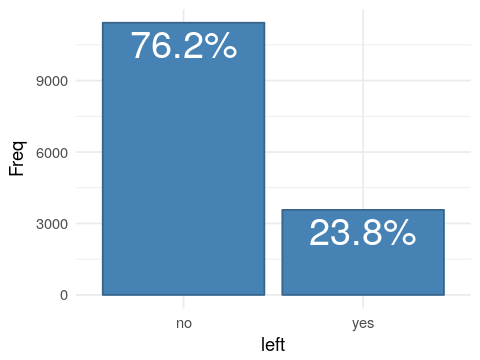

In [15]:
options(repr.plot.width = 4, repr.plot.height = 3)

# Calculate the frequency and proportion of each value.
df.left <- as.data.frame(table(df$left))
df.left <- mutate(df.left, left = Var1, Prop = Freq / sum(Freq))

# Plot a vertical bar chart.
ggplot(df.left, aes(x = left, y = Freq)) +
    geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
    geom_text(aes(label = paste0(100 * round(Prop, 3), '%')),
              vjust = 1.25, size = 8, colour = 'white') +
    theme_minimal()

So a little less than 1/4 of the total employees in the data set left the company.

#### Numerical features

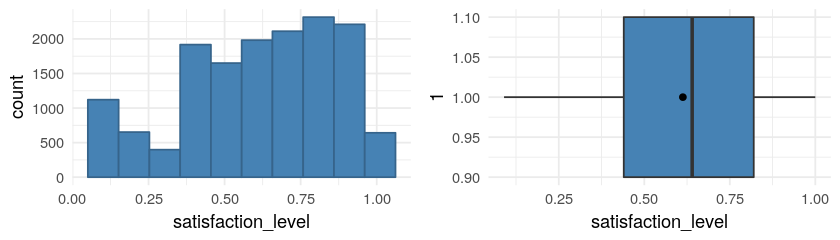

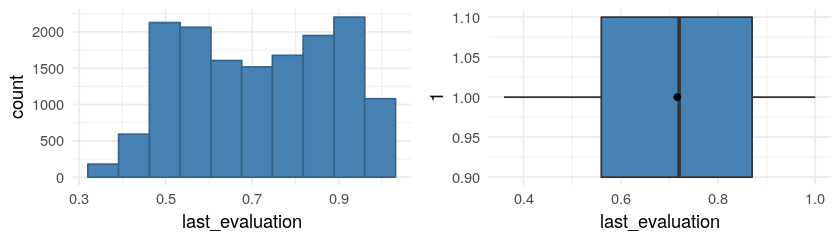

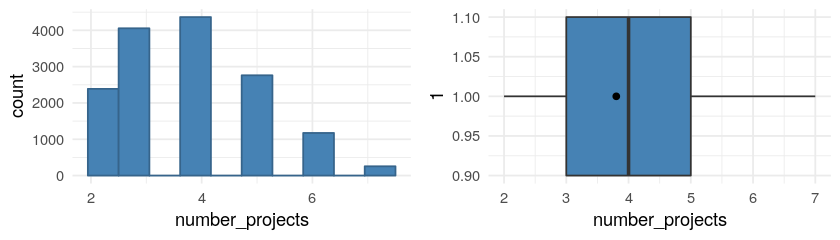

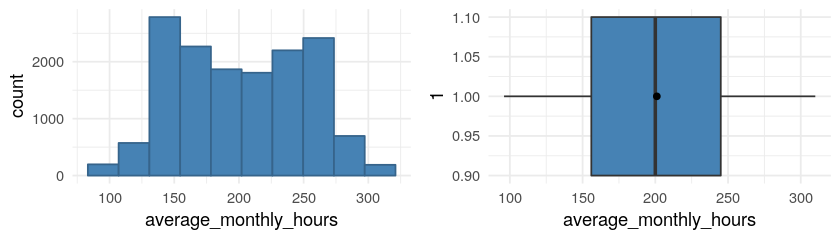

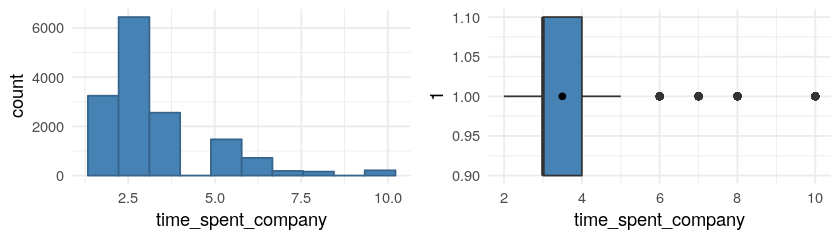

In [16]:
options(repr.plot.width = 7, repr.plot.height = 2)

for (x in names.numerical) {
    # Plot a 10-bin histogram.
    g1 <- ggplot(df, aes_string(x = x)) +
        geom_histogram(bins = 10, colour = 'steelblue4', fill = 'steelblue') +
        theme_minimal()

    # Plot a boxplot.
    g2 <- ggplot(df, aes_string(x = '1', y = x)) +
        geom_boxplot(fill = 'steelblue', width = 0.2) +
        stat_summary(fun.y = mean, geom = 'point') +
        coord_flip() +
        theme_minimal()

    multiplot(g1, g2, cols = 2)
}

The average employee satisfaction level in this company is about 0.6. Most values concentrate between 0.44 and 0.82. **Question:** how exactly does this satisfaction level correlate to the likelihood that an employee will leave the company?

In the last evaluation, most employees scored between 0.5 and 0.9. The minimum score was 0.3. **Question:** are these employees with lower scores the most likely to leave the company?

Employees may work on up to 7 projects. Most work on 3-5, and the minimum amount is 2. **Question:** how does the number of projects an employee works on correlate to their satisfaction level and salary? Are they well paid? Does that reflect their engagement in the company? Or could it be an indicator of overwork (thus, dissatisfaction)?

There are employees who work less than 150 hours per month, and others that work more than 250 hours per month. **Question:** again, could the extreme cases indicate overwork? Are these employees that work too much a relevant portion of those who left the company?

The vast majority of employees work in the company for (or left it in) less than 5 years (average is around 3 years). So this company seems to have a high turnover rate. **Question:** how much time the employees who have left the company used to spend there, in average?

#### Categorical features

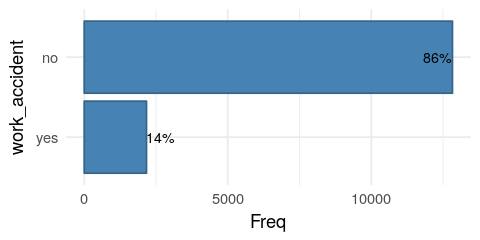

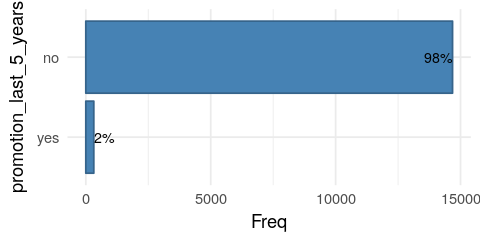

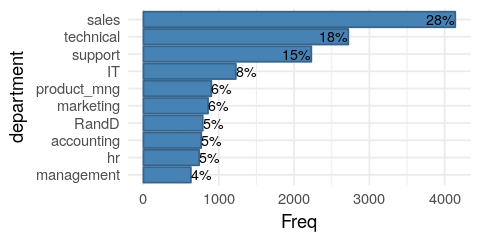

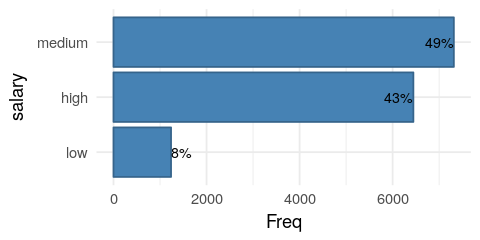

In [17]:
options(repr.plot.width = 4, repr.plot.height = 2)

for (x in names.categorical) {
    # Calculate the frequency and proportion of each value.
    df.x <- as.data.frame(table(df[, x]))
    df.x <- mutate(df.x, Var1 = reorder(Var1, Freq), Prop = Freq / sum(Freq))
    colnames(df.x) <- c(x, 'Freq', 'Prop')

    # Plot a horizontal bar chart.
    g <- ggplot(df.x, aes_string(x = x, y = 'Freq')) +
        geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
        geom_text(aes(label = paste0(100 * round(Prop, 2), '%')),
                  hjust = 'inward', size = 3) +
        coord_flip() +
        theme_minimal()

    print(g)
}

About 14.5% of the employees had already suffered some work accident. **Question:** could these accidents influence the likelihood that an employee will leave the company?

Only 2.1% of all employees have had any promotion in the last 5 years. **Question:** could this lack of recognition at the workplace be one of the main reasons for employees leaving the company in just a few years?

The sales team is the one with most collaborators. **Question:** are employees from specific departments more likely to leave the company, indicating that there could be management deficiencies in these departments?

The vast majority of employees receive low or medium salaries. **Question:** could a lower salary be another good predictor of employee dissatisfaction? How important is the salary to keep employees in the company?

### 2.2 Feature correlations

In [18]:
# Multiple correlation test function.
#
# Computes tests for association/correlation between paired samples
# represented in the rows and columns of a matrix.
#
# Source: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html
#
cor.mtest <- function(mat, conf.level = 0.95){
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- lowCI.mat <- uppCI.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    diag(lowCI.mat) <- diag(uppCI.mat) <- 1
    for(i in 1:(n-1)){
        for(j in (i+1):n){
            tmp <- cor.test(mat[,i], mat[,j], conf.level = conf.level)
            p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
            lowCI.mat[i,j] <- lowCI.mat[j,i] <- tmp$conf.int[1]
            uppCI.mat[i,j] <- uppCI.mat[j,i] <- tmp$conf.int[2]
        }
    }
    return(list(p.mat, lowCI.mat, uppCI.mat))
}

In [19]:
# Drop features that can't be converted to nunmbers (or that won't be used).
df.cor <- subset(df.copy1, select = -c(name, department, salary))

In [20]:
# Perform pairwise correlation tests and get the p-values.
p.mat <- cor.mtest(df.cor)[[1]]

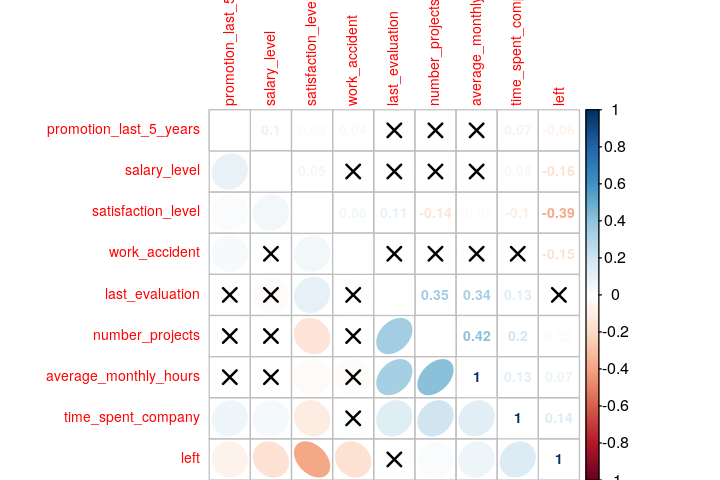

In [21]:
options(repr.plot.width = 6, repr.plot.height = 4)

# Plot the correlation matrix.
corrplot.mixed(cor(df.cor),
               lower = 'ellipse',
               upper = 'number',
               order = 'hclust',
               p.mat =  p.mat,
               sig.level = 0.05,
               tl.pos = 'lt',
               tl.cex = 0.7,
               number.cex = 0.7,
               pch.cex = 1.5)

The only feature that has a significant (negative) correlation to the target variable is (not surprisingly) `satisfaction_level`. That is, the dissatisfied employees in the data set (as measured by the company's feedback techniques) are more likely to leave the company. `salary_level` and `work_accident` are negatively correlated to the target too, but in a weaker degree (which is a little surprising for the latter). `time_spent_in_company` has a weak positive correlation to the target, i.e., it seems easier to find employees who left among those that work in the company for more time (in average).

An employee's last evaluation score is more positively correlated to their average monthly hours and the number of projects they worked on (and these two variables are positively correlated too: the more projects, the more monthly hours at work). But apparently such evaluation score does not correlate to the target variable.

`promotion_last_5_years` does not correlate significantly with any other feature. This may be due to the fact that we have too few cases of promoted employees in the data set.

As the `department` feature could not be included in the plot above (since it is a nominal variable), let's perform a simple hypothesis test at 5% confidence level to check whether our data shows strong evidence of correlation between this feature and the target variable (`left`).

In [22]:
# Perform a Pearson's chi-squared test.
chisq.test(table(df$left, df$department))


	Pearson's Chi-squared test

data:  table(df$left, df$department)
X-squared = 86.825, df = 9, p-value = 7.042e-15


As the p-value is much lower than 0.05, there is indeed some evidence that these features are correlated. So the `department` feature is possibly another good predictor for `left`.

### 2.3 Joint feature distributions

#### `left` versus `department`

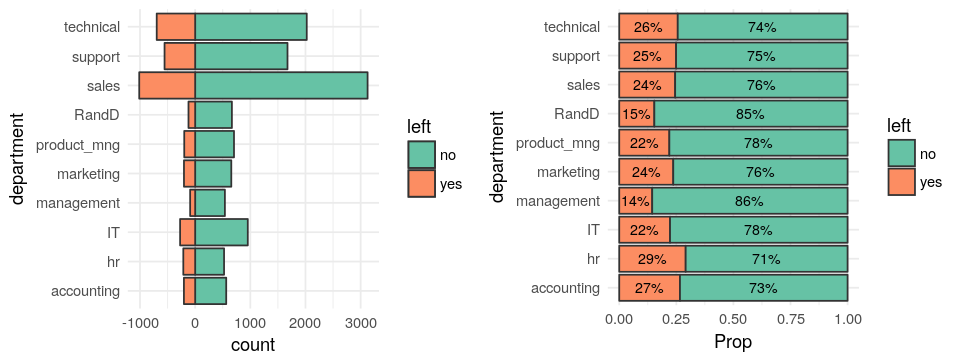

In [23]:
options(repr.plot.width = 8, repr.plot.height = 3)

# Plot a zero-centered stacked horizontal bar chart.
g1 <- ggplot(df, aes(x = department, fill = left)) +
    geom_bar(data = subset(df, left == 'no'), colour = '#333333') +
    geom_bar(data = subset(df, left == 'yes'), aes(y = -1 * ..count..), colour = '#333333') +
    coord_flip() +
    scale_fill_brewer(palette = 'Set2') +
    theme_minimal()

# Calculate the frequency and proportion of each value, grouped by department.
df.left.dep <- data.frame(prop.table(table(df$left, df$department)))
df.left.dep <- df.left.dep %>%
    group_by(Var2) %>%
    mutate(Prop = Freq / sum(Freq))
colnames(df.left.dep) <- c('left', 'department', 'Freq', 'Prop')

# Plot a 100% stacked horizontal bar chart.
g2 <- ggplot(df.left.dep, aes(x = department, y = Prop, fill = left)) +
    geom_bar(stat = 'identity', colour = '#333333') +
    geom_text(aes(label = paste0(100 * round(Prop, 2), '%')),
                  position = position_stack(vjust = 0.5), size = 3) +
    coord_flip() +
    scale_fill_brewer(palette = 'Set2') +
    theme_minimal()

multiplot(g1, g2, cols = 2)

The sales department has the largest absolute number of employees, so most employees that left the company were from that department too. However, in terms of relative proportions, the HR department is the one with the largest rate of employees who left, followed by the accounting department. But the rates are actually all very similar, except for the management and randD departments.

#### `left` versus numerical features

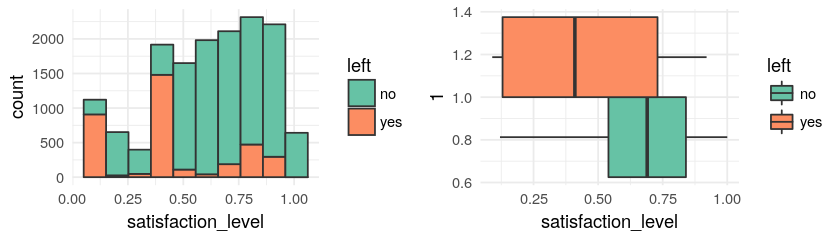

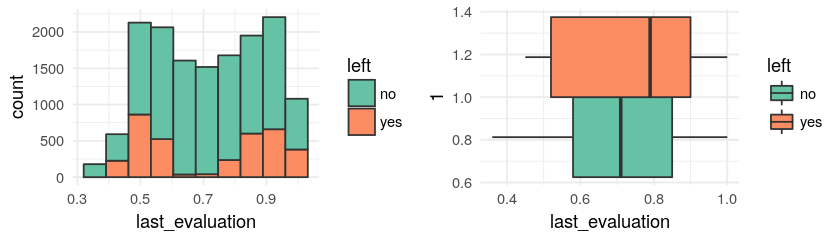

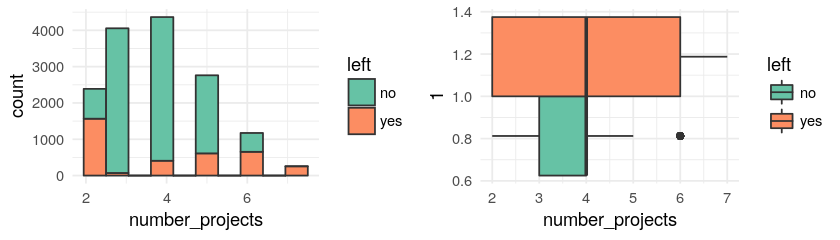

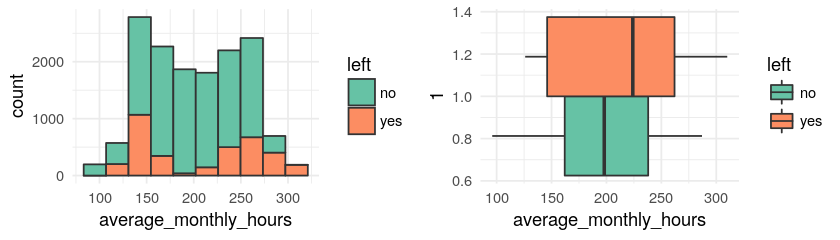

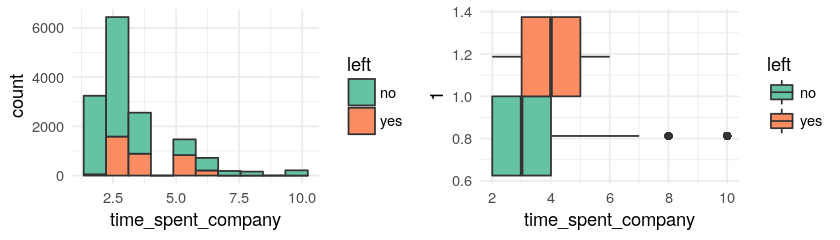

In [24]:
options(repr.plot.width = 7, repr.plot.height = 2)

for (x in names.numerical) {
    # Plot a 10-bin histogram for each target value.
    g1 <- ggplot(df, aes_string(x = x, fill = 'left')) +
        geom_histogram(bins = 10, colour = '#333333') +
        scale_fill_brewer(palette = 'Set2') +
        theme_minimal()

    # Plot a boxplot for each target value.
    g2 <- ggplot(df, aes_string(x = '1', y = x, fill = 'left')) +
        geom_boxplot() +
        coord_flip() +
        scale_fill_brewer(palette = 'Set2') +
        theme_minimal()

    multiplot(g1, g2, cols = 2)
}

In the above graphs we can see some additional trends:

The majority of employees who left the company are among those with lower or higher evaluation scores, but not among those with average scores. This could mean that both employees who have difficulties with their tasks, as well as employees who find their jobs "too easy" (perhaps being overqualified for the position?) are more likely to leave.

A similar trend was found in the number of projects. Actually, the majority - or even the totality - of the employees with 2 (the minimum) or 6+ projects have left! However, for the former group, it would be interesting to check if these employees were working on less projects because they weren't performing well at the job in the first place.

Again, a similar trend was found in the average monthly hours. The groups of employees who work too much, as well as those who work too little, contain both a bigger part of the employees that left the company. For the latter, it could be interesting to take a closer look at the individuals: were they working less because of sickness, family problems, depression, or something like that?

When it comes to the time (in years) that an employee spent working for the company, it looks like 3-5 years is the time range in which there is more chance an employee will leave. If he/she goes beyond 6 years, this chance drops to basically zero.

#### `left` versus other categorical features

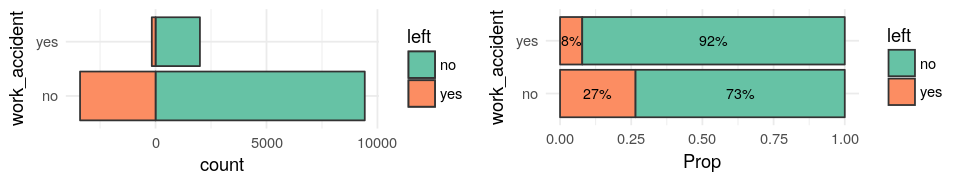

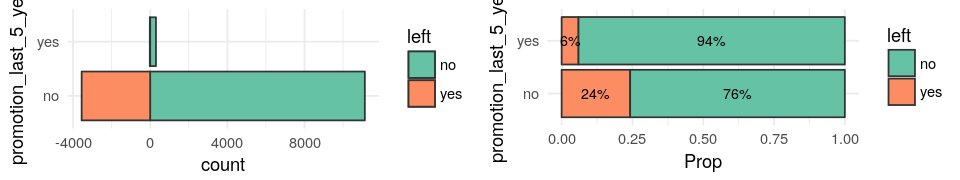

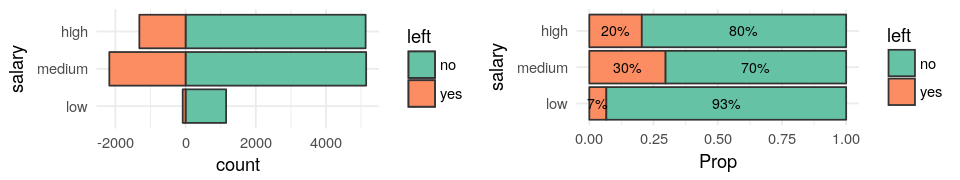

In [25]:
options(repr.plot.width = 8, repr.plot.height = 1.5)

for (x in names.categorical) {
    if (x != 'department') {
        # Plot a zero-centered stacked horizontal bar chart.
        g1 <- ggplot(df, aes_string(x = x, fill = 'left')) +
            geom_bar(data = subset(df, left == 'no'), colour = '#333333') +
            geom_bar(data = subset(df, left == 'yes'), aes(y = -1 * ..count..), colour = '#333333') +
            coord_flip() +
            scale_fill_brewer(palette = 'Set2') +
            theme_minimal()

        # Calculate the frequency and proportion of each value, grouped by the
        # feature whose name is contained in x.
        df.left.x <- data.frame(prop.table(table(df$left, df[, x])))
        df.left.x <- df.left.x %>%
            group_by(Var2) %>%
            mutate(Prop = Freq / sum(Freq))
        colnames(df.left.x) <- c('left', x, 'Freq', 'Prop')

        # Plot a 100% stacked horizontal bar chart.
        g2 <- ggplot(df.left.x, aes_string(x = x, y = 'Prop', fill = 'left')) +
            geom_bar(stat = 'identity', colour = '#333333') +
            geom_text(aes(label = paste0(100 * round(Prop, 2), '%')),
                          position = position_stack(vjust = 0.5), size = 3) +
            coord_flip() +
            scale_fill_brewer(palette = 'Set2') +
            theme_minimal()

        multiplot(g1, g2, cols = 2)
    }
}

It seems that the occurrence of work accidents do not encourage employees to leave, since only 8% of the employees who had some sort of accident ended up leaving the company.

About 1/4 of the employees that never got a promotion left the company. But the number of promoted ones is too small, so it is difficult to obtain further insights from this.

In the salary level, we see an expected trend: the better paid employees are, the lower is their likelihood of leaving.

So now we can trace a rough profile of the employees we want to detect: those who are low paid, who either perform bad or very well in the company's evaluation, who either work too much or too little (both in terms of number of projects and monthly hours), who are 3-5 years in the company (average), who don't work in the management or randD departments, and/or who feel dissatisfied with their jobs. Our predictive models will probably detect something close to this.

## 3 Preprocessing

In [26]:
# Split the data set into 2 subsets, one for model training and the other for tests.
train.index <- createDataPartition(df$left, p = 0.75, list = FALSE)
df.train <- df[train.index, ]
df.test <- df[-train.index, ]

In [27]:
dim(df.train)

[1] 11250    10

In [28]:
dim(df.test)

[1] 3749   10

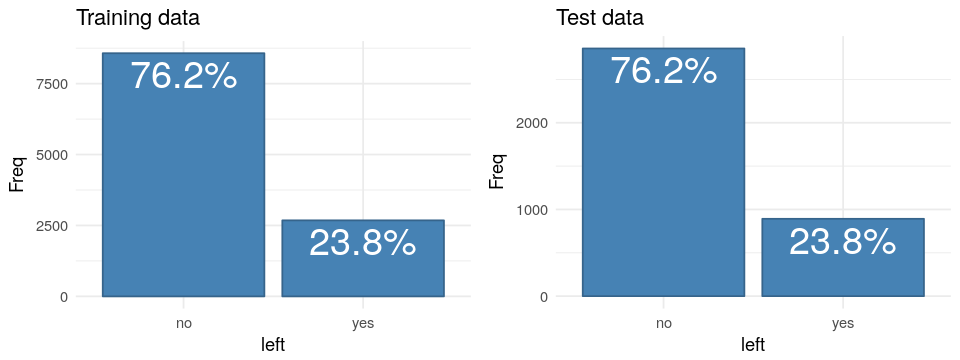

In [29]:
options(repr.plot.width = 8, repr.plot.height = 3)

# Calculate the frequency and proportion of each value.
df.train.left <- as.data.frame(table(df.train$left))
df.train.left <- mutate(df.train.left, left = Var1, Prop = Freq / sum(Freq))

# Plot a vertical bar chart.
g1 <- ggplot(df.train.left, aes(x = left, y = Freq)) +
    geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
    geom_text(aes(label = paste0(100 * round(Prop, 3), '%')),
              vjust = 1.25, size = 8, colour = 'white') +
    ggtitle("Training data") +
    theme_minimal()

# Calculate the frequency and proportion of each value.
df.test.left <- as.data.frame(table(df.test$left))
df.test.left <- mutate(df.test.left, left = Var1, Prop = Freq / sum(Freq))

# Plot a vertical bar chart.
g2 <- ggplot(df.test.left, aes(x = left, y = Freq)) +
    geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
    geom_text(aes(label = paste0(100 * round(Prop, 3), '%')),
              vjust = 1.25, size = 8, colour = 'white') +
    ggtitle("Test data") +
    theme_minimal()

multiplot(g1, g2, cols = 2)

Due to the nature of this problem, the kinds of features we have, the need to visualize and interpret the results, and the way the data is distributed, decision tree classifiers are good picks for our predictive models. Thus, scaling, normalizing, unskewing and some other common feature preprocessing steps are not really necessary here, since decision trees are quite robust and make no prior assumptions about the data distribution.

A feature selection step is surely convenient, but decision tree classifiers can do that by themselves.

So the only task here was to split the data set into two subsets, one for model training (75% of the data set) and other for testing and evaluating the trained model (25% of the data set). The partitioning was done in a way that preserved the distribution of the target variable equal in both subsets, as the graph shows.

## 4 Model training

In [30]:
# Configure the cross-validation.
control <- trainControl(method = 'cv',
                        number = 5,
                        classProbs = TRUE,
                        savePredictions = TRUE,
                        summaryFunction = twoClassSummary)

In total, 3 different decision tree classifiers will be tried to generate the predictive model. For each of them, the best combination of input parameters will be found using grid search and a 5-fold cross validation procedure. 

### 4.1 Classification and Regression Tree (CART)

In [31]:
# Train a predictive model using CART.
cart.grid <- expand.grid(cp = seq(0, 0.1, 0.01))
cart <- train(left ~ .,
              data = df.train,
              method = 'rpart',
              metric = 'ROC',
              trControl = control,
              tuneGrid = cart.grid)

In [32]:
# Print the model stats
cart

CART 

11250 samples
    9 predictor
    2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9000, 9001, 8999, 9000, 9000 
Resampling results across tuning parameters:

  cp    ROC        Sens       Spec     
  0.00  0.9744729  0.9922994  0.9201158
  0.01  0.9682364  0.9875163  0.9126510
  0.02  0.9663963  0.9802824  0.9145167
  0.03  0.9663963  0.9802824  0.9145167
  0.04  0.9603381  0.9690817  0.9167569
  0.05  0.9603381  0.9690817  0.9167569
  0.06  0.9584211  0.9526314  0.9212345
  0.07  0.9589611  0.9494809  0.9223560
  0.08  0.8340895  0.9809827  0.6730172
  0.09  0.8340895  0.9809827  0.6730172
  0.10  0.8340895  0.9809827  0.6730172

ROC was used to select the optimal model using  the largest value.
The final value used for the model was cp = 0. 

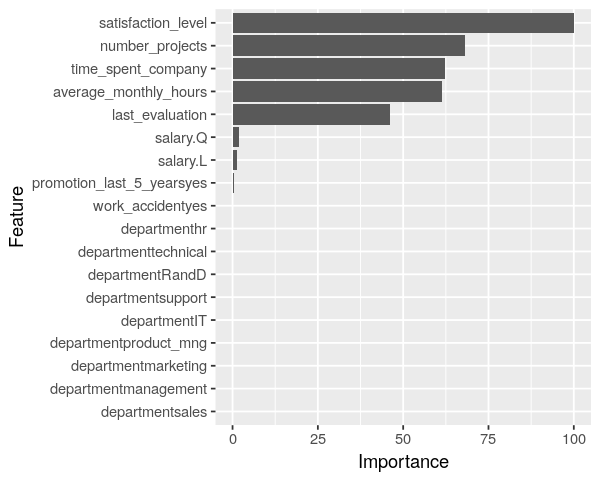

In [33]:
options(repr.plot.width = 5, repr.plot.height = 4)

# Plot the feature importances.
ggplot(varImp(cart))

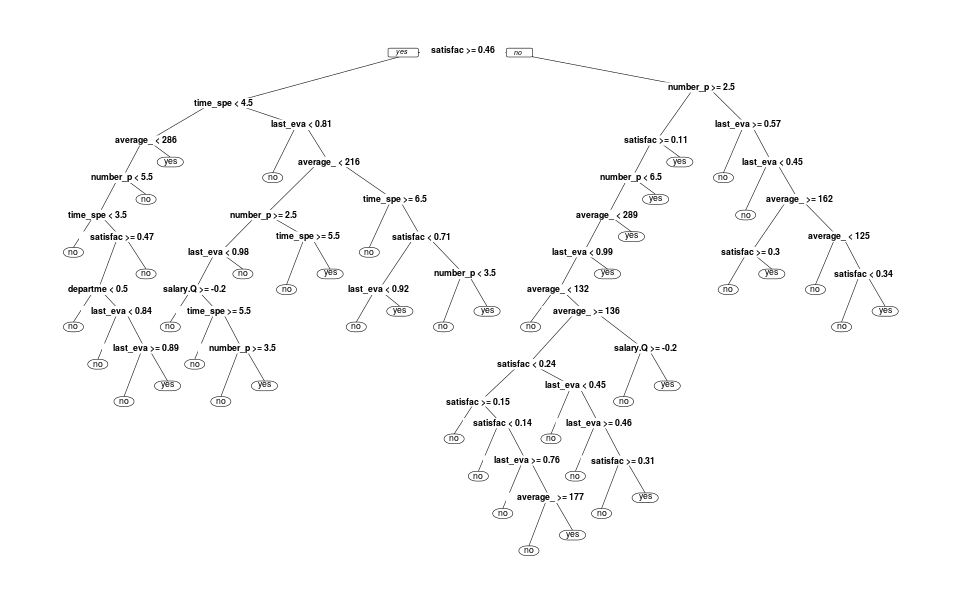

In [34]:
options(repr.plot.width = 8, repr.plot.height = 5)

# Plot the tree structure.
prp(cart$finalModel)

Our first classifier was built using the CART algorithm, which estimates a single decision tree to fit the data set.

In the validation sets considered by the 5-fold cross-validation procedure, this model achieved an average sensibility (true positive rate) of **99.23%** and an average specificity (true negative rate) of **92.01%** with the best combination of parameters. The average AUC (area under the ROC curve) was **97.45%**.

`satisfaction_level`, `number_projects`, `time_spent_company`, `average_monthly_hours` and `last_evaluation` were, in this order, the most important features used to make the predictions. The tree graph above shows exactly how these variables were considered, and in which order, to conduct the model to the final prediction.

### 4.2 Random Forest

In [35]:
# Train a predictive model using Random Forest.
rf.grid <- expand.grid(mtry = c(2, 7, 12, 17))
rf <- train(left ~ .,
            data = df.train,
            method = 'rf',
            metric = 'ROC',
            trControl = control,
            tuneGrid = rf.grid,
            importance = TRUE)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



In [36]:
# Print the model stats.
rf

Random Forest 

11250 samples
    9 predictor
    2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9000, 8999, 9001, 9000, 9000 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   2    0.9904373  0.9973165  0.8951109
   7    0.9938079  0.9977832  0.9656598
  12    0.9930000  0.9971999  0.9656598
  17    0.9919493  0.9963834  0.9645397

ROC was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 7. 

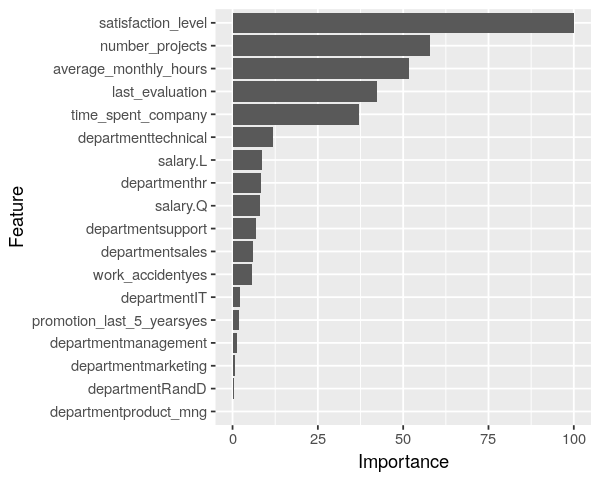

In [37]:
options(repr.plot.width = 5, repr.plot.height = 4)

# Plot the feature importances.
ggplot(varImp(rf))

Our second classifier was built using the Random Forest algorithm, which is an ensemble of hundreds of decision trees estimated from randomly sampled portions of the data set and then combined (final prediction = majority of votes).

In the validation sets considered by the 5-fold cross-validation procedure, this model achieved an average sensibility (true positive rate) of **99.78%** and an average specificity (true negative rate) of **96.57%** with the best combination of parameters. The average AUC (area under the ROC curve) was **99.38%**.

`satisfaction_level`, `number_projects`, `average_monthly_hours`, `last_evaluation` and `time_spent_company` were, in this order, the most important features used to make the predictions.

### 4.3 eXtreme Gradient Boosting (XGBoost)

In [38]:
xgb.grid <- expand.grid(nrounds = c(1000),
                        max_depth = c(8),
                        eta = c(0.01),
                        gamma = c(0),
                        subsample = c(1),
                        colsample_bytree = c(0.8),
                        min_child_weight = c(0.5))
xgb <- train(left ~ .,
             data = df.train,
             method = 'xgbTree',
             metric = 'ROC',
             trControl = control,
             tuneGrid = xgb.grid)

Loading required package: xgboost

Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



In [39]:
# Print the model stats.
xgb

eXtreme Gradient Boosting 

11250 samples
    9 predictor
    2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9001, 9000, 9000, 8999, 9000 
Resampling results:

  ROC        Sens       Spec     
  0.9919127  0.9968501  0.9428812

Tuning parameter 'nrounds' was held constant at a value of 1000

Tuning parameter 'min_child_weight' was held constant at a value of 0.5

Tuning parameter 'subsample' was held constant at a value of 1
 

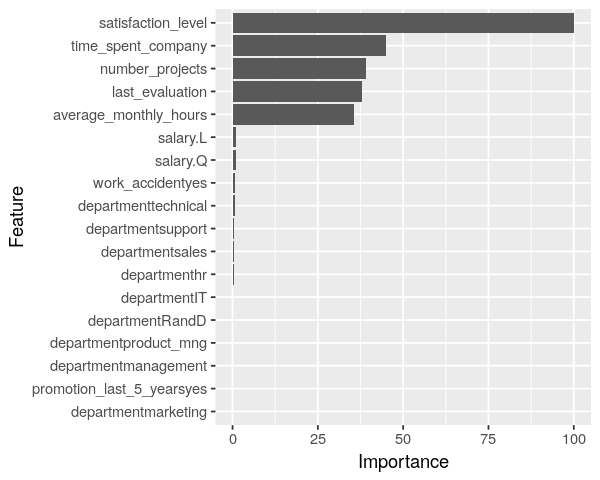

In [40]:
options(repr.plot.width = 5, repr.plot.height = 4)

# Plot the feature importances.
ggplot(varImp(xgb))

The third classifier was built using the eXtreme Gradient Boosting algorithm, which is (in this case) an ensemble of thousands of decision trees estimated from randomly sampled portions of the data set in a sequential manner, so that each tree tries to compensate the mistakes made by the previous ones, and then the better trees will have a greater weight in the final prediction.

In the validation sets considered by the 5-fold cross-validation procedure, this model achieved an average sensibility (true positive rate) of **99.69%** and an average specificity (true negative rate) of **94.29%** with the best combination of parameters. The average AUC (area under the ROC curve) was **99.19%**.

`satisfaction_level`, `time_spent_company`, `number_projects`, `last_evaluation` and `average_monthly_hours` were, in this order, the most important features used to make the predictions.

## 5 Model evaluation

### 5.1 Classification and Regression Tree (CART)

In [41]:
# Make predictions using the CART model.
cart.pred <- predict(cart, df.test)

In [42]:
# Print the confusion matrix and other statistics.
confusionMatrix(data = cart.pred, df.test$left, positive = 'yes')

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  2832   64
       yes   25  828
                                          
               Accuracy : 0.9763          
                 95% CI : (0.9709, 0.9809)
    No Information Rate : 0.7621          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9335          
 Mcnemar's Test P-Value : 5.626e-05       
                                          
            Sensitivity : 0.9283          
            Specificity : 0.9912          
         Pos Pred Value : 0.9707          
         Neg Pred Value : 0.9779          
             Prevalence : 0.2379          
         Detection Rate : 0.2209          
   Detection Prevalence : 0.2275          
      Balanced Accuracy : 0.9598          
                                          
       'Positive' Class : yes             
                                          

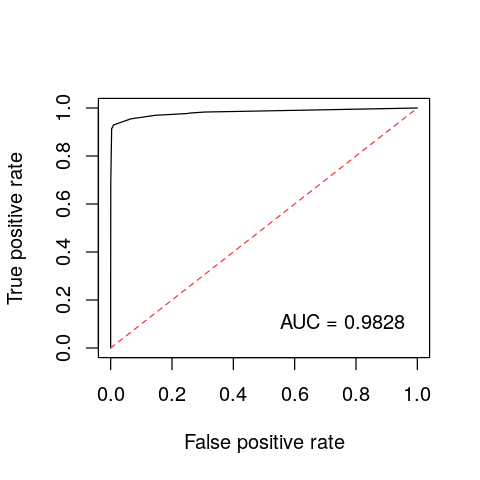

In [43]:
options(repr.plot.width = 4, repr.plot.height = 4)

# Plot the ROC curve and AUC.
cart.response <- predict(cart, df.test, type = 'prob')
cart.response <- prediction(cart.response$yes, df.test$left)
cart.performance <- performance(cart.response, measure = 'tpr', x.measure = 'fpr')
cart.auc <- performance(cart.response, measure = 'auc')
plot(cart.performance)
segments(0, 0, 1, 1, col = 'brown2', lty = 'dashed')
text(1, 0.1, paste('AUC =', round(cart.auc@y.values[[1]], 4)), pos = 2)

The CART model achieved a sensitivity of **92.83%**, a specificity of **99.12%** and an AUC of **98.28%** in the test set.

More than **97%** of the test instances were correctly classified according to the accuracy score.

### 5.2 Random Forest

In [44]:
# Make predictions using the Random Forest model.
rf.pred <- predict(rf, df.test)

In [45]:
# Print the confusion matrix and other statistics.
confusionMatrix(data = rf.pred, df.test$left, positive = 'yes')

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  2852   27
       yes    5  865
                                         
               Accuracy : 0.9915         
                 95% CI : (0.988, 0.9942)
    No Information Rate : 0.7621         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9763         
 Mcnemar's Test P-Value : 0.0002054      
                                         
            Sensitivity : 0.9697         
            Specificity : 0.9982         
         Pos Pred Value : 0.9943         
         Neg Pred Value : 0.9906         
             Prevalence : 0.2379         
         Detection Rate : 0.2307         
   Detection Prevalence : 0.2321         
      Balanced Accuracy : 0.9840         
                                         
       'Positive' Class : yes            
                                         

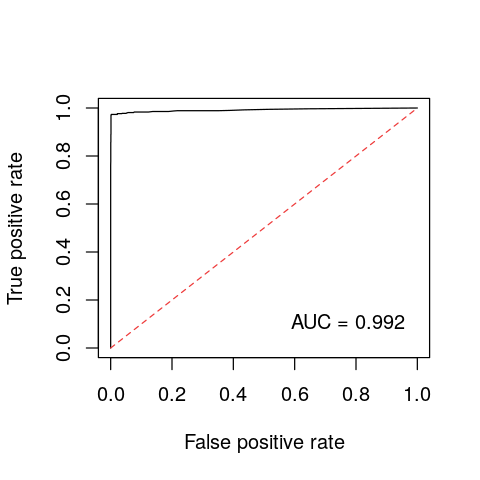

In [46]:
options(repr.plot.width = 4, repr.plot.height = 4)

# Plot the ROC curve and AUC.
rf.response <- predict(rf, df.test, type = 'prob')
rf.response <- prediction(rf.response$yes, df.test$left)
rf.performance <- performance(rf.response, measure = 'tpr', x.measure = 'fpr')
rf.auc <- performance(rf.response, measure = 'auc')
plot(rf.performance)
segments(0, 0, 1, 1, col = 'brown2', lty = 'dashed')
text(1, 0.1, paste('AUC =', round(rf.auc@y.values[[1]], 4)), pos = 2)

The Random Forest model achieved a sensitivity of **96.97%**, a specificity of **99.82%** and an AUC of **99.20%** in the test set.

More than **99%** of the test instances were correctly classified according to the accuracy score.

### 5.3 eXtreme Gradient Boosting (XGBoost)

In [47]:
# Make predictions using the XGBoost model.
xgb.pred <- predict(xgb, df.test)

In [48]:
# Print the confusion matrix and other statistics.
confusionMatrix(data = xgb.pred, df.test$left, positive = 'yes')

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  2850   45
       yes    7  847
                                          
               Accuracy : 0.9861          
                 95% CI : (0.9819, 0.9896)
    No Information Rate : 0.7621          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9612          
 Mcnemar's Test P-Value : 2.882e-07       
                                          
            Sensitivity : 0.9496          
            Specificity : 0.9975          
         Pos Pred Value : 0.9918          
         Neg Pred Value : 0.9845          
             Prevalence : 0.2379          
         Detection Rate : 0.2259          
   Detection Prevalence : 0.2278          
      Balanced Accuracy : 0.9736          
                                          
       'Positive' Class : yes             
                                          

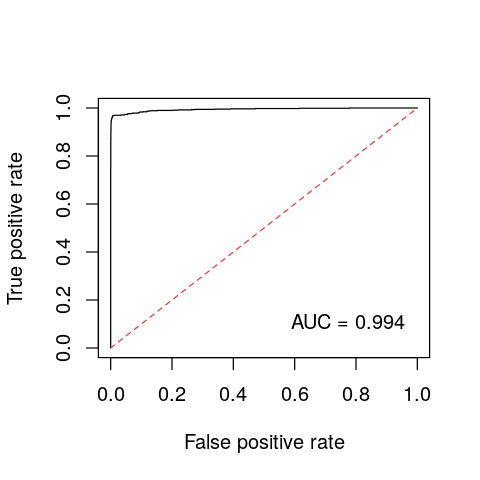

In [49]:
options(repr.plot.width = 4, repr.plot.height = 4)

# Plot the ROC curve and AUC.
xgb.response <- predict(xgb, df.test, type = 'prob')
xgb.response <- prediction(xgb.response$yes, df.test$left)
xgb.performance <- performance(xgb.response, measure = 'tpr', x.measure = 'fpr')
xgb.auc <- performance(xgb.response, measure = 'auc')
plot(xgb.performance)
segments(0, 0, 1, 1, col = 'brown2', lty = 'dashed')
text(1, 0.1, paste('AUC =', round(xgb.auc@y.values[[1]], 4)), pos = 2)

The XGBoost model achieved a sensitivity of **94.96%**, a specificity of **99.75%** and an AUC of **99.40%** in the test set.

More than **99%** of the test instances were correctly classified according to the accuracy score.

## 6 Conclusions

In summary, all the three classifiers perform great and are highly successful in predicting whether a new employee is likely to leave the company or not. More than that, these models help us to understand which are the variables that mainly influence each possible outcome.

Having a feature that directly measures employee satisfaction surely makes the job a little easier, but as all models have shown, there are other important predictors involved too: the number of projects, the average monthly hours, the last evaluation score and the years spent in the company are the main ones - just as we had already observed during the exploratory data analysis.

And now, with this new level of understanding of the problem, the company interested in reducing its turnover rate could implement some policies to better balance its workload among employees, improve training programs, do further research in order to find other sources of employee dissatisfaction, etc.